In [1]:
using DataFrames, CSV, CategoricalArrays
using Statistics, LinearAlgebra, Random
using Plots, ProgressBars

# Boston Data

In [2]:
    filename = "../Datasets/Boston.csv"
    data = DataFrame(CSV.File(filename))
    df = copy(data)
    dropmissing!(df)
    ndf = names(df)

14-element Vector{String}:
 "crim"
 "zn"
 "indus"
 "chas"
 "nox"
 "rm"
 "age"
 "dis"
 "rad"
 "tax"
 "ptratio"
 "black"
 "lstat"
 "medv"

In [50]:
head(df)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222


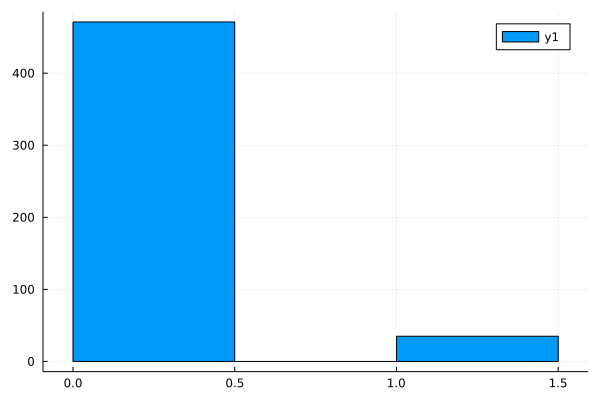

In [146]:
    name_of_y = :medv
    names_of_x =  ["rm", "lstat", "dis"] 
    names_of_z =[:chas] # :rad
    dfy = df[!, name_of_y]
    dfX = df[!, names_of_x]
    dfZ = df[!, names_of_z]

    Xa, Za, ya = Array(dfX), Array(dfZ), Array(dfy)
histogram(Za)

In [135]:
sum(Za, dims = 1)

1×1 Matrix{Int64}:
 35

# QGPLSIM fitting

In [150]:
include("./src/qgplsim.ji")
include("./src/supportFunctions.ji")
include("RealWorldData.ji")

mc_simu (generic function with 3 methods)

In [155]:
# Xa, Za, ya = boston()
X = scaler(Xa, 1)
Hy = (maximum(ya) - minimum(ya)) 
y = ya ./ Hy
y = y .- mean(y)
Z, zmap = categ_binary(Za) # [:, 1]
categ, index = collection(Z)
n,p = size(X)  
n,q = size(Z)
zmap

1-element Vector{Any}:
 Dict{Any, Any}(0 => [1], 1 => [0])

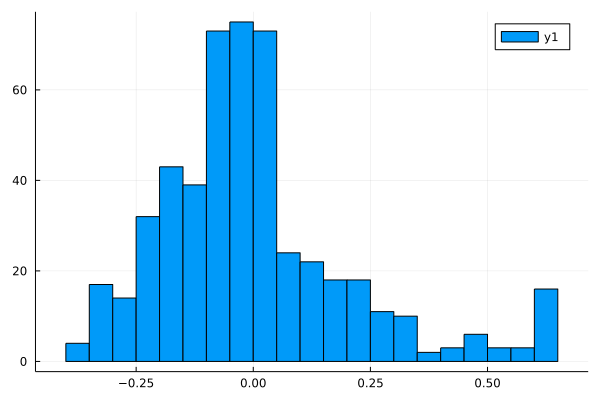

In [156]:
histogram(y)

In [160]:
tau = [0.5]
method = "qr" # mean for mean regression, optim and mm for qr regression
nfold = 4
Z = Z .* 0.0
index_test, index_train = nsplit_z(Z, nfold)
Alpha = []
Theta = []
Beta = []
Gamma = []
tau = [0.5]
for k in 1:nfold
    indt, indr = index_test[k], index_train[k]
    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr] 
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
    tr_model = qgplsim.model(Xr, Zr, yr, tau, width_exp)
    qgplsim.estimator(tr_model)
    qgplsim.print_model(tr_model)
    ylx = Xt * tr_model.alpha
    ylz = Zt * tr_model.beta
    gv = qgplsim.predict(tr_model, Xt, Zt)
    yp = (gv + ylx + ylz)
    push!(Alpha, tr_model.alpha)
    push!(Beta, tr_model.beta)
    push!(Theta, tr_model.theta)
    push!(Gamma, tr_model.gamma)
    println("rmse of fold $k: ", rmsd(yp, yt) * Hy, "\n")
end

alpha => [0.0009, -0.0924, 0.0412]
theta => [0.7889, -0.2436, -0.5641]
gamma => [0.0]
beta => [0.0]
rmse of fold 1: 5.744994482100346

alpha => [0.0035, -0.081, 0.0501]
theta => [0.6825, -0.3633, -0.6342]
gamma => [0.0]
beta => [0.0]
rmse of fold 2: 4.876731715086735

alpha => [0.0226, -0.0805, 0.0517]
theta => [0.5869, -0.3145, -0.7461]
gamma => [0.0]
beta => [0.0]
rmse of fold 3: 4.668538684197444

alpha => [0.0054, -0.1035, 0.032]
theta => [0.7982, -0.1398, -0.586]
gamma => [0.0]
beta => [0.0]
rmse of fold 4: 4.551438211793235



In [161]:
alpha_, theta_, beta_, gamma_ = mean(Alpha), mean(Theta), mean(Beta), mean(Gamma)

([0.008093466070450635, -0.08935648256366098, 0.0437612859358982], [0.7141355606536999, -0.26527700564142764, -0.6326026548518991], [0.0], [0.0])

In [162]:
pred_model = qgplsim.model(X, Z, y, tau, width_exp)
pred_model.alpha, pred_model.theta, pred_model.beta, pred_model.gamma = alpha_, theta_, beta_, gamma_ 
ylx = X * pred_model.alpha
ylz = Z * pred_model.beta
gv = qgplsim.predict(pred_model, X, Z)
yp = gv + ylx + ylz  
rmsd(yp, y) * Hy

4.855428949903388

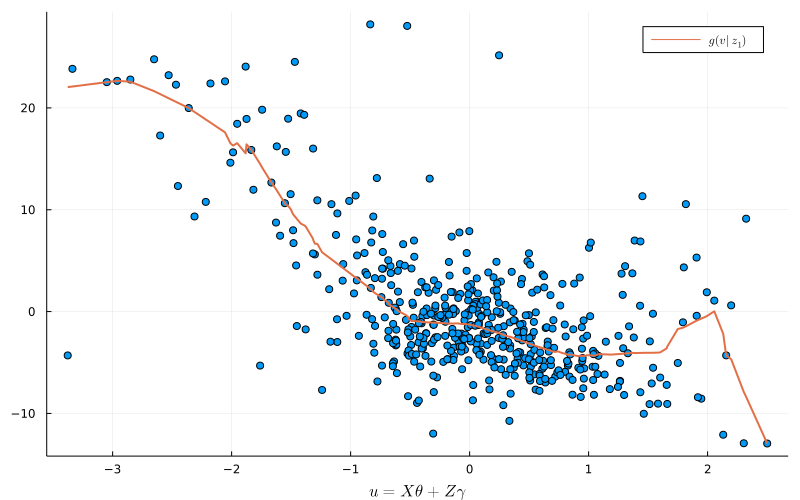

In [163]:
categ, index = collection(Z)
ncateg = length(categ)
fig = plot(layouts = (1,ncateg))
str_label = [L"g(v|z_1)", L"g(v|z_2)", L"g(v|z_3)"]
vv = X * pred_model.theta + Z * pred_model.gamma
for k in 1:ncateg
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk] * -(1)^(k + 1)
    ypk = gv[indk] * Hy   
    ytk = (y[indk] - ylx[indk] - ylz[indk]) * Hy

    sort_ind = sortperm(vk)

    scatter!(pk, vk, ytk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = str_label[k])


end

xlabel!(fig[1], L"u = X \theta + Z \gamma")
plot!(size = (800, 500))
Plots.savefig("gv_qr.png")
fig

In [127]:
using Base.Threads
n_pt = 25
nmc = n_pt*Threads.nthreads()
bias = zeros(nmc)


Theta = zeros(nmc, p)
Gamma = zeros(nmc, q)
Alpha = zeros(nmc, p)
Beta  = zeros(nmc, q)

width_exp = -0.2


@threads for i in 1:Threads.nthreads()
    for j in 1:n_pt
    t = (i - 1)*n_pt + j 

indr, indt = get_train_index(Z, ntrain)
# shuffle!(indt)

    Xr = X[indr, :]
    yr = y[indr] 
    Zr = Z[indr, :]

    Xt = X[indt, :]
    yt = y[indt]  
    Zt = Z[indt, :]
    # Zr = Zr .* 0
    # Zt = Zt .* 0
    qsmodel = qgplsim.model(Xr, Zr, yr, tau, width_exp)
    qgplsim.estimator(qsmodel)
    # qsmodel1 = qgplsim.model(Xr, Zr, yr, 0.1)
    # qsmodel9 = qgplsim.model(Xr, Zr, yr, 0.9)
    # @time qgplsim.estimator(qsmodel1)
    # @time qgplsim.estimator(qsmodel9)
    
    Theta[t, :], Gamma[t, :],
    Alpha[t, :], Beta[t, :] = qsmodel.theta, qsmodel.gamma, qsmodel.alpha, qsmodel.beta
        
    vv = Xt * qsmodel.theta
    ylx = Xt * qsmodel.alpha
    ylz = Zt * qsmodel.beta
    yp = qgplsim.predict(qsmodel, Xt, Zt, dy) + ylx  + ylz
    # bias = rho.(yt - yp, tau)./2
    bias[t] = rmsd(yp, yt)
    end
end

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitq

In [128]:
mean(Theta, dims = 1)

1×3 Matrix{Float64}:
 0.175836  0.153085  0.261998

In [129]:
mean(Alpha, dims = 1)

1×3 Matrix{Float64}:
 0.0602323  -0.0805001  0.0220578

In [130]:
mean(Beta, dims = 1)

1×8 Matrix{Float64}:
 -0.0375348  0.0298781  0.073846  …  0.0607702  -0.0145236  0.0253648

In [131]:
mean(Gamma, dims = 1)

1×8 Matrix{Float64}:
 -0.104043  -0.068186  0.0902514  …  -0.0161912  0.0306618  -0.0469779

In [132]:
mean(bias)

0.12266105044322327

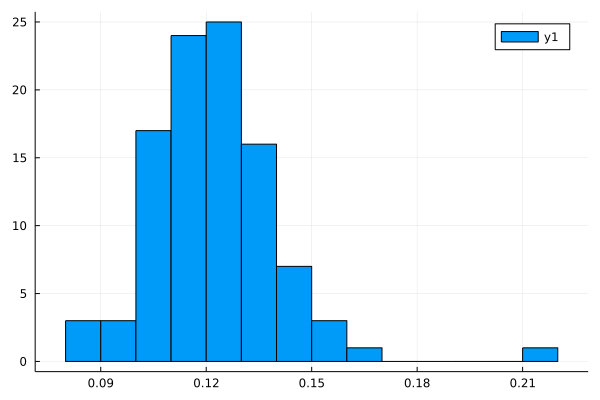

In [133]:
histogram(bias)